An implemetation of Kansa's method for surface mesh BVP's

In [1]:
%load_ext autoreload
%autoreload 2

from MRBF import MRBF
import pygeodesic
import pygeodesic.geodesic as geodesic
import numpy as np
import vtk
from vtk_helpers import *
from polymesh import *
from matplotlib import pyplot as plt

import plotly.graph_objects as go 

In [2]:
from polymesh import PointData
from polymesh.cells import T3 as CellData
from polymesh import PolyData

Read in the file for the triangle mesh

In [3]:
filename = r'data/flat_triangular_mesh.txt'
result = geodesic.read_mesh_from_file(filename)
if result:
    points, faces = result

Gather the embeded coordinates of the mesh and plot it. Here it is 2d

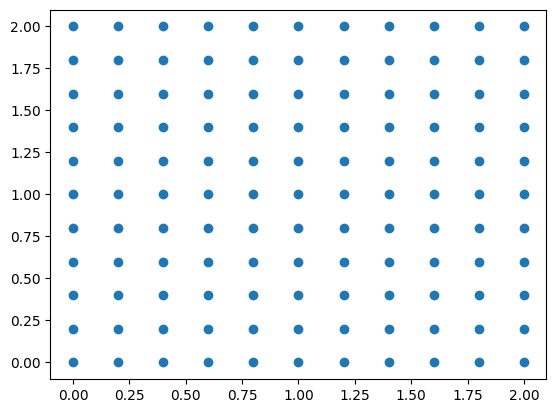

In [4]:
xs = np.transpose(points)[0]
ys = np.transpose(points)[1]
zs = np.transpose(points)[2]

xmin = np.min(xs)
ymin = np.min(ys)

for i in range(len(points)):
    points[i][0] -= xmin
    points[i][1] -= ymin

xs = np.transpose(points)[0]
ys = np.transpose(points)[1]
zs = np.transpose(points)[2]
fig, ax = plt.subplots()
ax.scatter(xs, ys)



Now we are going to collect points along the boundary

In [5]:
xmin = np.min(xs)
xmax = np.max(xs)
ymin = np.min(ys)
ymax = np.max(ys)
boundaryInds = []
for i, point in enumerate(points):
    if point[0] == xmin or point[0] == xmax or point[1] == ymin or point[1] == ymax:
        boundaryInds.append(i)


Lets look at the boundary now

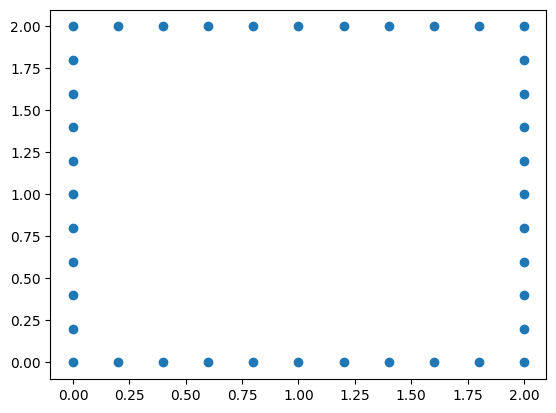

In [6]:
boundary = [points[i] for i in boundaryInds]
xb = np.transpose(boundary)[0]
yb = np.transpose(boundary)[1]
plt.scatter(xb, yb)

Here is a true visualization of the mesh

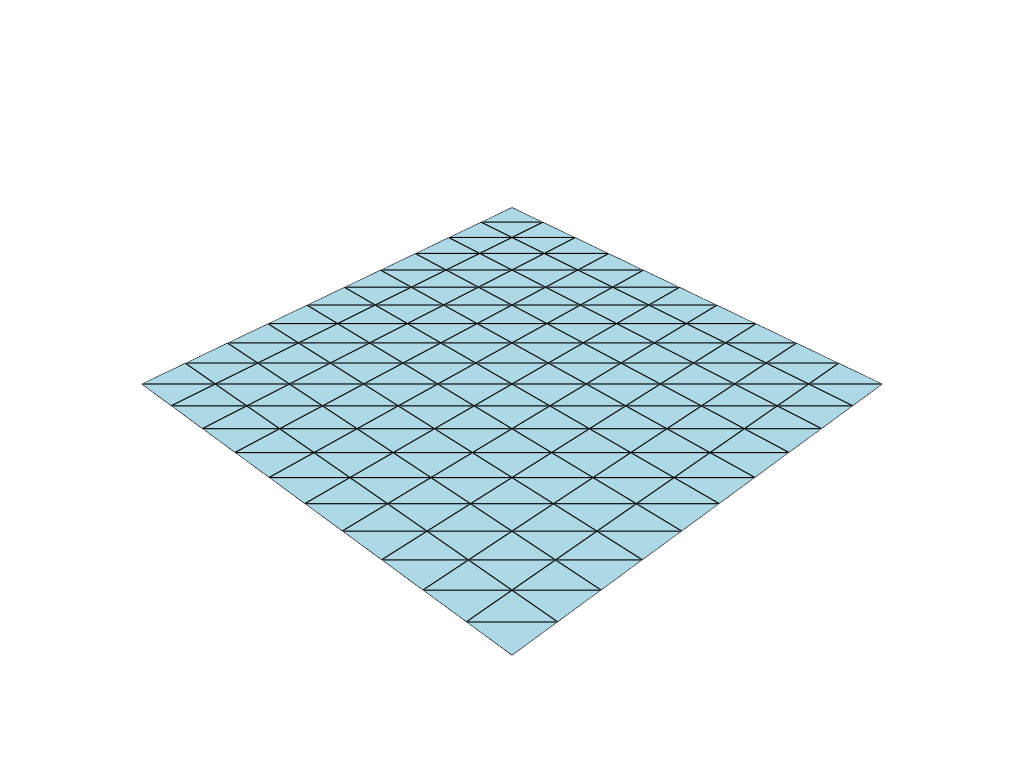

In [7]:

pd = PointData(coords=points)
cd = CellData(topo=faces)
mesh = PolyData(pd, cd)
mesh.plot(notebook=True, jupyter_backend="static", theme="document")

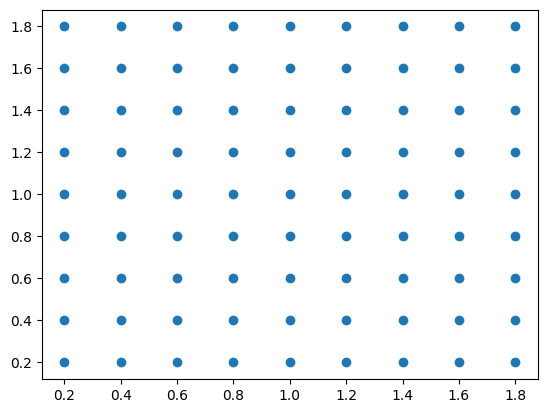

In [8]:
interiorInds = []
for i, point in enumerate(points):
    if point[0] != xmin and point[0] != xmax and point[1] != ymin and point[1] != ymax:
        interiorInds.append(i)

interior = np.array([points[i] for i in interiorInds])
plt.scatter(interior.T[0], interior.T[1])

Regroup the points into interior and closure and recombine them

In [9]:
N_i = len(interior)
N = len(points)

newInds = []
for i in range(N):
    if i < N_i:
        newInds.append(interiorInds[i])
    else:
        newInds.append(boundaryInds[i - N_i])


In [10]:
inverse = np.zeros(N)
for i, j in enumerate(newInds):
    inverse[j] = i


In [11]:
newPoints = np.array([points[i] for i in newInds])
newFaces = []

for face in faces:
    i = face[0]
    j = face[1]
    k = face[2]
    newFace = [int(inverse[i]), int(inverse[j]), int(inverse[k])]
    newFaces.append(newFace)

newPoints = np.asarray(newPoints)
newFaces = np.asarray(newFaces)

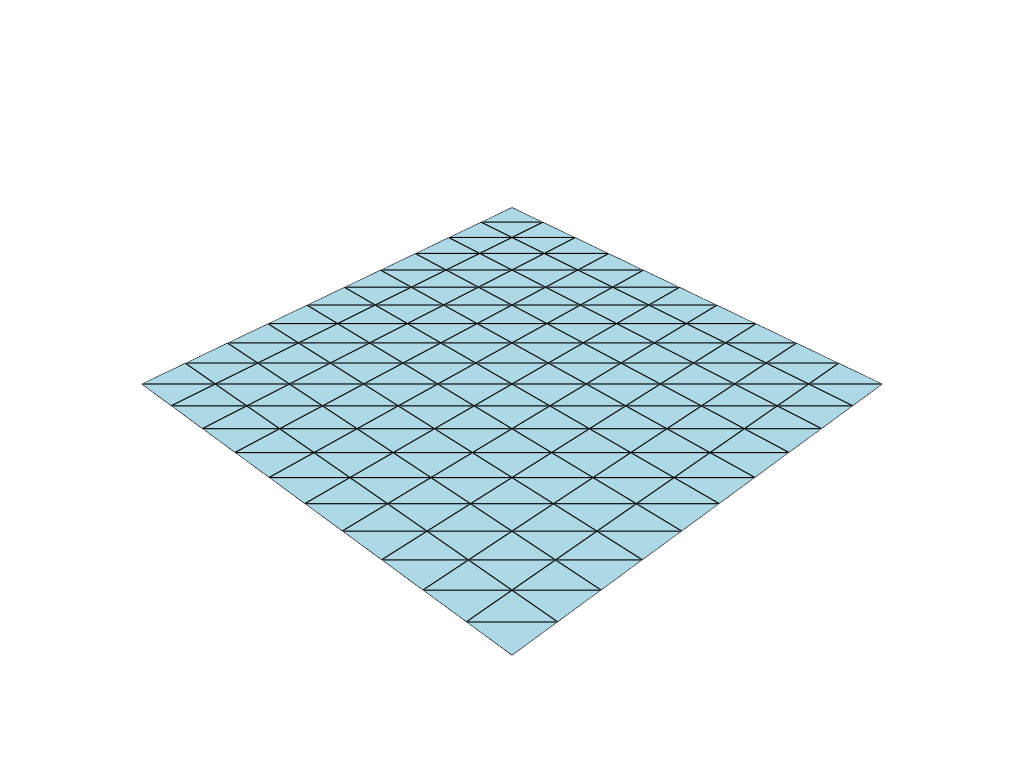

In [12]:
pd2 = PointData(coords=newPoints)
cd2 = CellData(topo=newFaces)
mesh2 = PolyData(pd2, cd2)
mesh2.plot(notebook=True, jupyter_backend="static", theme="document")

In [13]:
import robust_laplacian
from plyfile import PlyData
import polyscope as ps
import scipy.sparse.linalg as sla


Lets solve a boundary value problem now. Let us say $\Delta u(x, y) = 0$ and $u(x, 0) = u(x, 2) = u(0, y) = 0$ and $u(2, y) = sin(\pi y/2)$.

First we compute the laplacian matrix of the surface

In [14]:
L, M = robust_laplacian.mesh_laplacian(newPoints, newFaces)
n_eig = 15
evals, evecs = sla.eigsh(L, n_eig, M, sigma=1e-8)

# Visualize
ps.init()
ps_mesh = ps.register_surface_mesh("my mesh", points, faces)
for i in range(n_eig):
    ps_mesh.add_scalar_quantity("eigenvector_"+str(i), evecs[:,i], enabled=True)
ps.show()

In [15]:
Minv = np.linalg.inv(M.toarray())
L_s = np.matmul(Minv, L.toarray())


In [16]:
F = np.zeros(N)
for i in range(N):
    if i < N_i:
        F[i] = 0
    else:
        x = newPoints[i][0]
        y = newPoints[i][1]
        if x == 2:
            #print(y)
            F[i] = np.sin(np.pi*y/2)
        else:
            F[i] = 0

In [17]:
from kansa import Kansa

In [18]:
k = Kansa(newPoints, newFaces, L_s, F, N_i)

solved system of equations


In [19]:
Solution = np.array([k.Interpolate(i) for i in range(len(newPoints))])

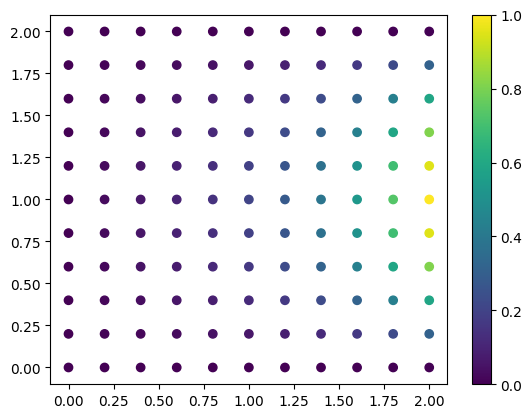

In [20]:
plt.scatter(newPoints.T[0], newPoints.T[1], c=Solution)
plt.colorbar()

Analytical solution is given by $u(x, y) = \frac{sinh(\pi x/2)}{sinh(\pi)} sin(\pi y/2)$

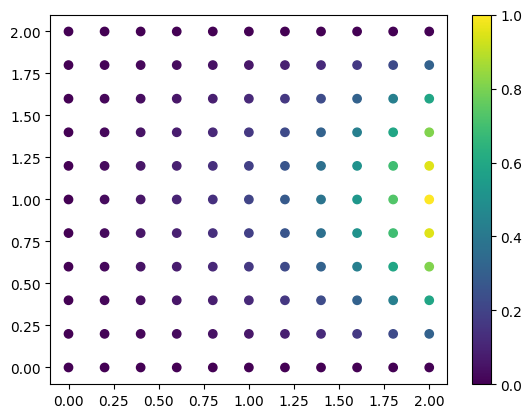

In [21]:



analytical = []


for point in newPoints:
    x = point[0]
    y = point[1]
    analytical.append(np.sinh(np.pi*x/2)*np.sin(np.pi*y/2)/np.sinh(np.pi))

analytical = np.asarray(analytical)
plt.scatter(newPoints.T[0], newPoints.T[1], c=analytical)
plt.colorbar()



In [42]:
print(np.linalg.norm(Solution - analytical, 2))

relativeErrors = []
for i in range(len(analytical)):
    error = 100*(Solution[i] - analytical[i])/(analytical[i])
    relativeErrors.append(error)

print(relativeErrors)
print(np.mean(np.where(relativeErrors != np.inf, relativeErrors, 0)))

0.01373536596768434
[1.734964201859945, 1.7349641636767228, 1.7349641568178598, 1.7349641525865356, 1.7349641536478615, 1.7349641435085676, 1.7349641375070561, 1.7349641468899386, 1.7349641433209633, 1.656295324976902, 1.6562952903792283, 1.6562952798332433, 1.656295271062559, 1.6562952656403183, 1.656295274151001, 1.656295268215014, 1.656295274388087, 1.6562952799851698, 1.5315371373435926, 1.531537144543499, 1.5315371405428704, 1.531537137545973, 1.5315371303357719, 1.5315371385607381, 1.5315371368149702, 1.5315371429015616, 1.5315371357819811, 1.3686092718080163, 1.3686092773337217, 1.368609275682514, 1.3686092781611034, 1.3686092760440667, 1.3686092796147291, 1.3686092783965527, 1.3686092756734414, 1.3686092790449793, 1.1761011730589626, 1.176101177656275, 1.1761011771134549, 1.1761011782727482, 1.176101178649411, 1.1761011762331515, 1.176101174962586, 1.1761011753267545, 1.1761011800746257, 0.9619928590737938, 0.961992860287496, 0.9619928611916927, 0.9619928616741071, 0.9619928626

C:\Users\alexs\AppData\Local\Temp\ipykernel_35260\3556992817.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  error = 100*(Solution[i] - analytical[i])/(analytical[i])
c:\Users\alexs\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Now Let us try using the weak laplacian instead

In [23]:
k2 = Kansa(newPoints, newFaces, L.toarray(), F, N_i)
Solution2 = np.array([k.Interpolate(i) for i in range(len(newPoints))])

solved system of equations


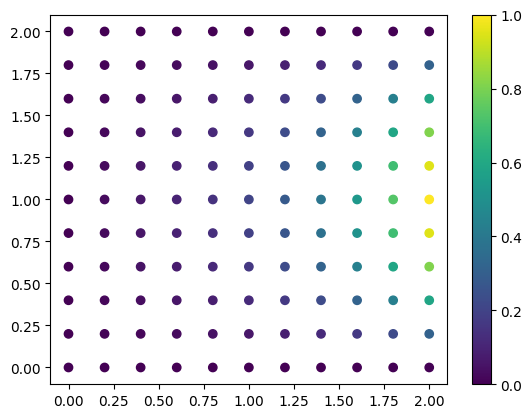

In [24]:
plt.scatter(newPoints.T[0], newPoints.T[1], c=Solution2)
plt.colorbar()

In [25]:
ps.init()
ps_mesh = ps.register_surface_mesh("my mesh", newPoints, newFaces)
ps_mesh.add_scalar_quantity("strong laplacian interpolated solution", Solution, enabled=True)
ps.show()

In [26]:
ps.init()
ps_mesh = ps.register_surface_mesh("my mesh", newPoints, newFaces)
ps_mesh.add_scalar_quantity("weak laplacian interpolated solution", analytical, enabled=True)
ps.show()

In [27]:
perturbedPoints = newPoints.copy()

In [28]:
for i, point in enumerate(perturbedPoints):
    x = point[0]
    y = point[1]

    perturbedPoints[i][2] = np.sin(np.pi*x/2)*np.sin(np.pi*y/2)

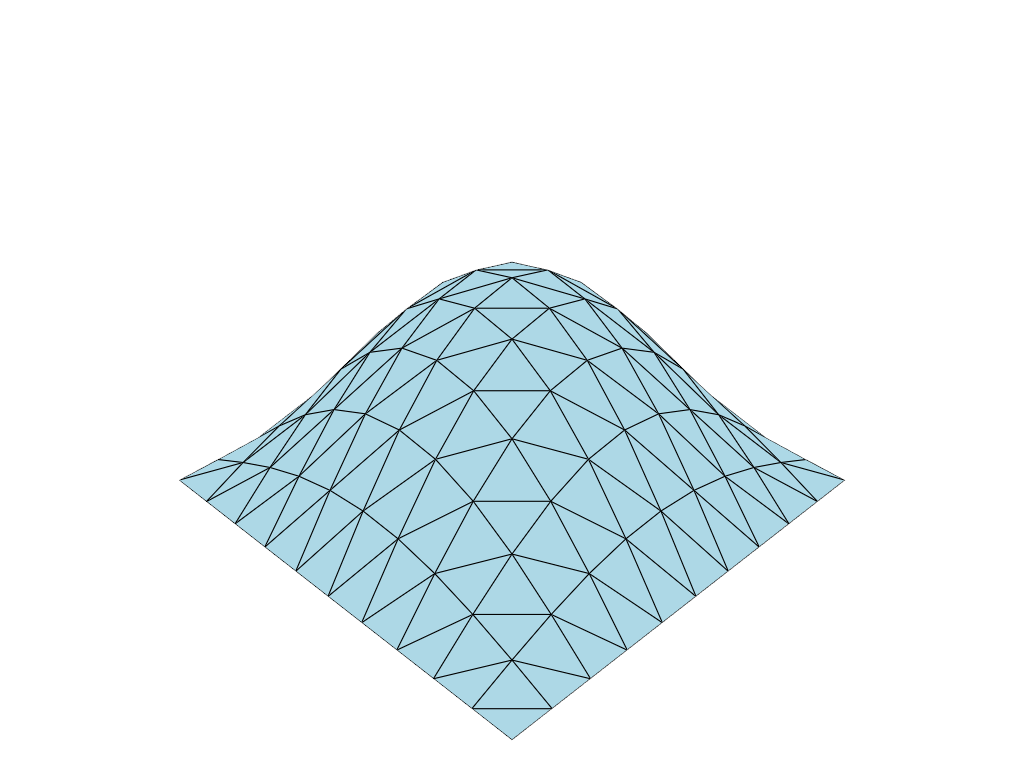

In [29]:
pd3 = PointData(coords=perturbedPoints)
cd3 = CellData(topo=newFaces)
mesh3 = PolyData(pd3, cd3)
mesh3.plot(notebook=True, jupyter_backend="static", theme="document")

In [30]:
L2, M2 = robust_laplacian.mesh_laplacian(perturbedPoints, newFaces)
n_eig = 15
evals, evecs = sla.eigsh(L2, n_eig, M2, sigma=1e-8)

# Visualize
ps.init()
ps_mesh = ps.register_surface_mesh("my mesh", points, faces)
for i in range(n_eig):
    ps_mesh.add_scalar_quantity("eigenvector_"+str(i), evecs[:,i], enabled=True)
ps.show()


In [31]:
Minv2 = np.linalg.inv(M2.toarray())
L_s2 = np.matmul(Minv, L2.toarray())

In [32]:
k3 = Kansa(perturbedPoints, newFaces, L_s2, F, N_i)

solved system of equations


In [33]:
Solution3 = np.array([k3.Interpolate(i) for i in range(len(perturbedPoints))])

In [34]:
ps.init()
ps_mesh = ps.register_surface_mesh("my mesh", perturbedPoints, newFaces)
ps_mesh.add_scalar_quantity("strong laplacian interpolated solution", Solution3, enabled=True)
ps.show()